# # 프로그램 기본 설정

In [758]:
# import

%matplotlib inline

from IPython.display import display

import re
import math
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import random

import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

#pandas에서 DataFrame을 요약해서 표시하지 않도록 설정
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# head로 표시할 데이터 갯수 
print_row_count = 3



# 줄 구분 표시 출력 
def print_line() :
  print ("\n------------------------------------------------")
def print_line_m() :
  print ("\n-----------------------")
def print_line_s() :
  print ("\n----------")


colors = sns.color_palette('pastel')[0:5]

## 함수 정의

In [75]:
# 부트 스트렙 case 01
def bootstrap( list_input , sample_count , repeat_count) :
  return_list = []
  for _ in range(repeat_count):
    sample = np.random.choice( list_input, sample_count, replace=True)
    return_list.append(sample.mean())
  #print ( return_list)
  return np.array(return_list)


## 기초 데이터 로딩

In [17]:
#  정제된 data loading 

# Data 로드
df_tmp = pd.read_csv( "https://raw.githubusercontent.com/LamuneGitHub/AI15_Prj_01/main/vgames2_after_cleaning_01.csv" , sep=","  , header=0  ) 
df_target = df_tmp


In [18]:
# 데이터 type 재 지정
df_target.info()

df_target.Platform = df_target.Platform.astype('category')
# (TODO) 연도 컬럼의 카테고리 값의 순서 지정
#df_target.Year = df_target.Year.astype('category')
df_target.Genre = df_target.Genre.astype('category')
df_target.Type = df_target.Type.astype('category')


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16241 entries, 0 to 16240
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Platform     16241 non-null  object
 1   Year         16241 non-null  int64 
 2   Genre        16241 non-null  object
 3   NA_Sales     16241 non-null  int64 
 4   EU_Sales     16241 non-null  int64 
 5   JP_Sales     16241 non-null  int64 
 6   Other_Sales  16241 non-null  int64 
 7   Type         16241 non-null  object
dtypes: int64(5), object(3)
memory usage: 1015.2+ KB


# # 분석 작업

## 1. 최종 분석 목표 
## **# 다음 분기에 어떤 게임을 설계해야 하는가 ?**

### 1.1 목표 상세 정의
    ## 최종 목표 요청사항 상세 정의 
    = 1 단계 
        * 어떤 장르를 개발해야 하는가?
        * 어떤 플렛폼용으로 개발해야 하는가?
        * 어떤 지역( 언어지원 , 주요 마켓팅 역량 집중 )을 주요 타겟으로 잡아야 하는가?

    = 2 단계
        목표 -> 각 장르별로 매출이 높을 확률 ? 베이지안 
            A : hit 게임
            B : 장르(각)

            P(A|B) = P(B|A) * P(A) / P(B)

        목표 -> 각 플렛폼 별로 매출이 높을 확률  ? 베이지안
            A : hit 게임
            B : 플렛폼(각)

            P(A|B) = P(B|A) * P(A) / P(B)

        목표 -> 각 지역별로 언어지원,집중 마켓팅을 했을때 매출이 높을 확률  ? 베이지안
            A : hit 게임
            B : 지역(각)

            P(A|B) = P(B|A) * P(A) / P(B)


    = 3 최종 선택은 ?
        * 최고로 높은 확률의 조합이 정답이 아니다.
            개발팀의 자원에 따라 취사 선택 및 전략의 선택이 필요 하다.
            -> 각각의 데이터를 모두 전달 후 상황에 맞게 전략을 선택할 수 있게 해주자

            ex) 블루오션을 , 레드오션
        
        * 분석 결과의 해석은 관점에 따라서 달라질 수 있다.
            - a장르의  hit 게임의 확률이 높다는 것은
                - a장르를 좋아하는 사람이 많다는 의미
                - a장르에 높은 개발력 , 혹은 충성도를 가지고 있는 경쟁사가 있다는 의미
                    ( 반대의 경우 높은 개발력을 가진 회사가 적다 혹은 신규 시장이다. 로 해셕할 수도 있다. )
            - 개발 전략을 수립하는 과정에서 계속 재 해석이 필요할 것이다. 

                -> 요청 사항이 ... 최신 트렌드 , 성공할 확률이 높은 선택지를 찾아줘로 느껴졌기 때문에 첨부한 첨언임

        * 95%의 신뢰도를 가지도록 분석하였지만 , 5%의 확률은 일상에서 매우 흔하게 자주 발생한다.
            TRPG 게임을 하다보면 20면체 주사위를 굴릴때 크리티컬이 나와서 끝났다고 생각하던 때에 역전승을 하거나
                다 이겼다고 생각될 때 펌블이 나와서 망하는 경우가 아주 흔하게 발생한다는 것을 기억해라

        * 개발팀의 역량 과 능력, 가지고 있는 자원에 대한 파악이 핵심이고 성공으로 향하는 올바른 시작이다.
        

### 1.2 필요한 데이터
    * 과거의 데이터는 현재의 상활을 파악하는데 의미있는 정보가 아닐 수 있다.
        -> 최신의 데이터를 사용 -> 5년 ? 10년?
    
    * 구해야(필요한) 하는 확률 값 
        - P ( 장르(각각) | hit 게임 )
        - P ( hit 게임 )
        _ P ( 장르(각각) )
        
        - P ( 플랫폼(각각) | hit 게임 )
        - P ( 플랫폼(각각) )
        
        - P ( 지역(각각) | hit 게임 )
        - P ( 지역(각각) )

    * hit 게임의 정의
        (!문제점) 출고량이 높은 게임의 기준이 모호함

        - 출고량이 높은 게임에 label 표시 -> 데이터가 너무 많아서 불가능
        - 특정값 이상 -> 연도별 특성 고려하는 것이 올바를 것 같음
            -> 연도별 특성을 고려하지 않는다면 특정값은 어떻게 정하는게 좋을까?
        - 매출량 상위 25% 를 출고량이 높은것 ?
        - 매출량 정규화 후 상위 5% ? 10% ?
        - kmeans로 데이터 그룹핑 후 구분
            - 매출을 기준으로 
                하하 ~ 상상 9 단계로 클러스터링 후 분류해 볼까?
            
            * 분석 데이터는 부트 스트렙을 해야 하는가?
                - 부트스트랩의 평균값은 모수의 평균값과 같다
                - 모수의 연도별, 지역별 매출 평규값을 구할 수 있다.
                -> 분석데이터는 부트스트렙한 데이터를 사용한다.

            *  적당한 그룹수를 찾기
                -> (TODO) elbow 메소드 이용해서 값 정하기 시도 해보자
        -> kmeans로 클러스러팅 진행하여 
            최 상위 매출 그룹을 hit-게임으로 정의
        

### 1.3 분석 진행

* 사용할 데이터의 연도 정하기  

    -> 최근 10년의 데이터를 사용

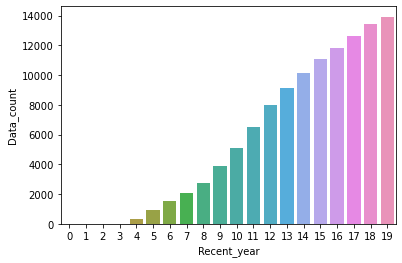

In [123]:
#(v) 사용할 데이터의 연도 정하기
df = df_target

max_year = df.Year.max()
max_year

list_data_count = [ len(df[df.Year >= max_year - i ]) for i in range ( 20 ) ] 
list_data_count

recent_year =  list( range(len(list_data_count)) )  
recent_year

df_ploat = pd.DataFrame (
    {
        "Recent_year" : recent_year ,
        "Data_count" : list_data_count
    }
)

sns.barplot ( data = df_ploat  ,x ='Recent_year' ,  y = 'Data_count')

#(v) 분석에 사용하는 data는 최근 10년으로 정함
recent_year_boundary = 10

<AxesSubplot:xlabel='sum_Sales', ylabel='count'>

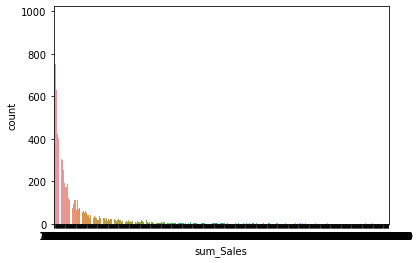

In [113]:
sns.countplot ( data = df , x='sum_Sales')

* hit 게임 기준 정하기

    -> K-means 분류.    
    -> 8 단계중 마지막 2 단계 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000000 entries, 6874 to 759
Data columns (total 10 columns):
 #   Column       Non-Null Count    Dtype   
---  ------       --------------    -----   
 0   Platform     1000000 non-null  category
 1   Year         1000000 non-null  int64   
 2   Genre        1000000 non-null  category
 3   NA_Sales     1000000 non-null  int64   
 4   EU_Sales     1000000 non-null  int64   
 5   JP_Sales     1000000 non-null  int64   
 6   Other_Sales  1000000 non-null  int64   
 7   Type         1000000 non-null  category
 8   sum_Sales    1000000 non-null  int64   
 9   label        1000000 non-null  category
dtypes: category(4), int64(6)
memory usage: 57.2 MB
   label       max       min  count  cum_sum
3      3  21389999  13470000    NaN      NaN
6      6  12210000   8840000    NaN      NaN
1      1   8490000   5980000    NaN      NaN
7      7   5659999   3610000    NaN      NaN
5      5   3530000   2140000    NaN      NaN
2      2   2110000   11000

/var/folders/jn/rsqz7wy50rqf16w210vtbm1w0000gn/T/ipykernel_22111/3883318476.py:66: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_label_max = df_label_max.append ( df_insert )
/var/folders/jn/rsqz7wy50rqf16w210vtbm1w0000gn/T/ipykernel_22111/3883318476.py:66: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_label_max = df_label_max.append ( df_insert )
/var/folders/jn/rsqz7wy50rqf16w210vtbm1w0000gn/T/ipykernel_22111/3883318476.py:66: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_label_max = df_label_max.append ( df_insert )
/var/folders/jn/rsqz7wy50rqf16w210vtbm1w0000gn/T/ipykernel_22111/3883318476.py:66: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas

3    3
6    6
Name: label, dtype: int64

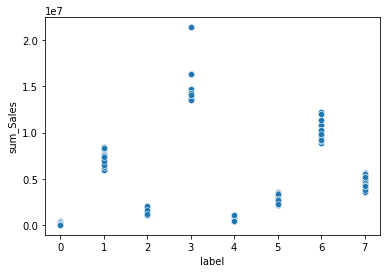

In [361]:
# (v) hit-게임 분류하기( kmeans)

# (v) 매출 합계 컬럼 생성 
df['sum_Sales'] = df.NA_Sales + df.EU_Sales + df.JP_Sales + df.Other_Sales
df.head()


# data backup
df_org = df.copy()

#(v) 최근연도 df 추출
df_recent = df[df.Year >= max_year - (recent_year_boundary-1) ].copy()
len(df_recent)

#(v) 부트 스트랩 ( 10만개 )
df_boot = df_recent.sample(n=1000000, replace=True)
df_boot.head()
df_boot.info()


# 작업 df = 
df = df_boot

#(TODO) 히스토그램으로  갯수 vs 값 출력해 보기
#sns.histplot ( df.sum_Sales )

#(v) Kmeans 실행 하여 클러스터 나누기
# K-means 클러스터링 분석
kmeans = KMeans( random_state=42)

# (v) 부트스트랩을 한 data를 기준으로 클러스터링 진행
# (TODO) 혹시 셈플(원본) 데이터를 클러스터링 분류 기준으로 잡아야 하는가?
kmeans.fit_transform( np.array(df.sum_Sales.to_list()).reshape(-1, 1))    #(TODO) reshape(-1, 1) 해주어야 하는 이유 확인

# # 최근연도의_부트스트렙_ 셈플 데이터를 클러스터링 하기
# kmeans._transform(np.array(df_boot.sum_Sales.to_list()).reshape(-1, 1))
cluster_labels = kmeans.labels_

#(TODO)결과가 몇개의 클러스터 나뉘었는지 확인하는 간단한 방법이 뭐였더라?)
set_cluster = set(cluster_labels )
len(set_cluster)

#(v) 어느 클러스터가 최고 매출 클러스터인지 확인 
df['label'] = cluster_labels
df['label'] = df['label'].astype('category')

#(TODO) y값이 정상으로 출력되지 않는 이유는?
sns.scatterplot ( data = df , y= 'sum_Sales' , x = 'label' )

#[v] 어느 그룹까지를 hit-game으로 보면 좋을지 결정 하기
# (TODO) 어떤 방법으로 나누는 것이 좋을까? 

# K-Means
df_label_max = pd.DataFrame ()
for i in range (8) :
        df_insert = pd.DataFrame(
                        {
                                'label' : i ,
                                'max' : df[df.label == i ].sum_Sales.max() , 
                                'min' : df[df.label == i ].sum_Sales.min() , 
                                'count' : df[df.label == i ].count()
                        }
                        , index=[i]
                )
        #print(df_insert)
        df_label_max = df_label_max.append ( df_insert )

#(v) max() 값 순으로 정렬하여 출력하는 방법은?
df_label_max.sort_values(by='max' , axis=0, ascending=False, inplace=True)
df_label_max['cum_sum'] = df_label_max['count'].cumsum()
print(df_label_max)


# 상위 10% 값의 경우에는? 
upper = np.percentile(df.sum_Sales, 90) 
print ( f" 상위 10% =  {upper}  ")


# #(v) 프로그램적으로 최고값 클러스터를 찾아내는 방법은?
# cluster_hit_game = df_label_max.iloc[:2]['label']
# cluster_hit_game


In [229]:
#(v) 프로그램적으로 최고값 클러스터를 찾아내는 방법은?
# hit game의 cluster 정하기
list_cluster_hit_game = df_label_max.iloc[:2]['label'].values.tolist()
print (list_cluster_hit_game)

[3, 1]



* (v)- 확률값 구하기



In [341]:
#(v)- p ( hit 게임)
df_label_ratio = df['label'].value_counts(normalize=True ,dropna = True)
P_hit = df_label_ratio.sort_values( )[:2].sum()
display( P_hit )

# hit 게임
#df_hit = df[ ((df['label'] == 3 ) | ( df['label'] == 1 ))  ]
df_hit = df.query ( "label in @ list_cluster_hit_game "   )
#(TODO) in 으로 조회 하기
#df[ (df['label'] in list_cluster_hit_game) ]
#list_cluster_hit_game = 3, 1

# (v)- P ( 장르(각각) | hit 게임 )
col_name = 'Genre'
df_temp = df_hit[col_name].value_counts(normalize=True ) 
df_P_Genre_ratio_bar_hitGame = df_temp[df_temp > 0 ].to_frame("ratio")
display(df_P_Genre_ratio_bar_hitGame)

# (v)_ P ( 장르(각각) )
df_temp = df[col_name].value_counts(normalize=True ) 
df_P_Genre_ratio = df_temp[df_temp > 0 ].to_frame("ratio")
display(df_P_Genre_ratio)

# (v)- P ( 플랫폼(각각) | hit 게임 )
col_name = 'Platform'
df_temp = df_hit[col_name].value_counts(normalize=True ) 
df_P_Platform_ratio_bar_hitGame = df_temp[df_temp > 0 ].to_frame("ratio")
display(df_P_Platform_ratio_bar_hitGame)

# (v)- P ( 플랫폼(각각) )
df_temp = df[col_name].value_counts(normalize=True ) 
df_P_Platform_ratio = df_temp[df_temp > 0 ].to_frame("ratio")
display(df_P_Platform_ratio)

# (v)- P ( 지역(각각) | hit 게임 )
# (v)- P ( 지역(각각) )

    # # -> 아래 쪽에서 별도 구현


0.004902

,ratio
Shooter,0.422685
Action,0.134843
Misc,0.119339
Role-Playing,0.112811
Platform,0.102815
Simulation,0.054876
Racing,0.052632


,ratio
Action,0.311885
Role-Playing,0.117154
Adventure,0.099909
Sports,0.099066
Misc,0.093851
Shooter,0.081007
Racing,0.045754
Fighting,0.040645
Simulation,0.033008
Platform,0.030916


,ratio
X360,0.371481
3DS,0.267646
PS3,0.206038
PS4,0.093023
Wii,0.061812


,ratio
PS3,0.180797
X360,0.130004
3DS,0.128672
PSV,0.105880
PC,0.094525
PS4,0.087034
PSP,0.080889
XOne,0.054339
Wii,0.051164
DS,0.048194


In [352]:
df_P_Genre_ratio_bar_hitGame.loc['Shooter'] 
df_P_Genre_ratio.loc['Shooter']
df_P_Genre_ratio_bar_hitGame.loc['Shooter'] * P_hit / df_P_Genre_ratio.loc['Shooter']

ratio    0.025578
Name: Shooter, dtype: float64

In [376]:
sri_ratio = (df_P_Genre_ratio_bar_hitGame.loc['Shooter'] * P_hit / df_P_Genre_ratio.loc['Shooter'])
print( sri_ratio.values[0] )

0.025578036465984423


#### 장르별 hit 게임 확률

,Genre,ratio
Shooter,Shooter,0.025578
Platform,Platform,0.016302
Simulation,Simulation,0.008150
Misc,Misc,0.006233
Racing,Racing,0.005639
Role-Playing,Role-Playing,0.004720
Action,Action,0.002119


<AxesSubplot:xlabel='Genre', ylabel='ratio'>

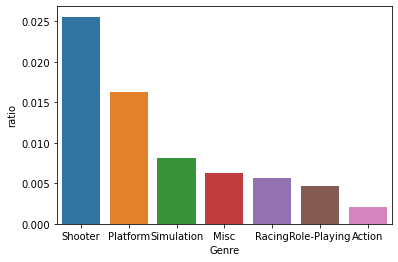

In [417]:
# 장르별 hit 게임 확률 (베이지안)
# """        A : hit 게임
#             B : 장르(각)

#             P(A|B) = P(B|A) * P(A) / P(B)
# """

# hit 게임의 장르
#P_hitGame_bar_Genre =  df_P_Genre_ratio_bar_hitGame [] * P_hit / P_ge
list_Genre_hit = df_P_Genre_ratio_bar_hitGame.index 

# P (hit 게임 | 각 장르별 )
df_P_hitGame_bar_Genre = pd.DataFrame()
#df_P_hitGame_bar_Genre.columns = ['Genre','ratio']
#display ( df_P_hitGame_bar_Genre)

for genre in list_Genre_hit :
    sri_ratio = (df_P_Genre_ratio_bar_hitGame.loc[genre] * P_hit / df_P_Genre_ratio.loc[genre])
    #print ( f" ratio = { sri_ratio } : {df_P_Genre_ratio_bar_hitGame.loc[genre] } *  {P_hit}  / { df_P_Genre_ratio.loc[genre]} "      )
    df_insert = pd.DataFrame ({
        "Genre" : genre ,
        "ratio" :  sri_ratio.values[0] # 값만 
    }, index = [genre] )
    df_P_hitGame_bar_Genre = pd.concat( [df_P_hitGame_bar_Genre , df_insert] , axis= 0)

# 정렬
df_P_hitGame_bar_Genre = df_P_hitGame_bar_Genre.sort_values( by=['ratio'] , ascending= False )
display(df_P_hitGame_bar_Genre)


# # 시각화
sns.barplot ( data = df_P_hitGame_bar_Genre , x = 'Genre' , y = 'ratio' )
#(TODO) 퍼센트 값 추가



In [471]:
df_P_hitGame_bar_Genre['ratio'].round(3)*100

Shooter         2.6
Platform        1.6
Simulation      0.8
Misc            0.6
Racing          0.6
Role-Playing    0.5
Action          0.2
Name: ratio, dtype: float64

#### 플렛폼 별 hit 게임 확률

,Platform,ratio
X360,X360,0.014007
3DS,3DS,0.010196
Wii,Wii,0.005922
PS3,PS3,0.005586
PS4,PS4,0.005239


<AxesSubplot:xlabel='Platform', ylabel='ratio'>

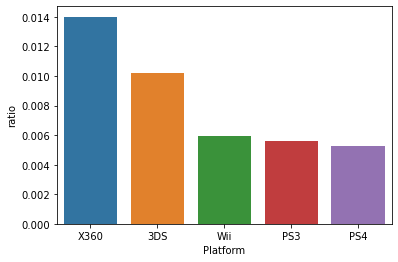

In [425]:
""""
        목표 -> 각 플렛폼 별로 매출이 높을 확률  ? 베이지안
            A : hit 게임
            B : 플렛폼(각)

            P(A|B) = P(B|A) * P(A) / P(B)
"""

# hit 게임의 장르
#P_hitGame_bar_Genre =  df_P_Genre_ratio_bar_hitGame [] * P_hit / P_ge
list_Platform_hit = df_P_Platform_ratio_bar_hitGame.index 

# P (hit 게임 | 각 장르별 )
df_P_hitGame_bar_Platform = pd.DataFrame()
#df_P_hitGame_bar_Genre.columns = ['Genre','ratio']
#display ( df_P_hitGame_bar_Genre)

for platform in list_Platform_hit :
    sri_ratio = (df_P_Platform_ratio_bar_hitGame.loc[platform] * P_hit / df_P_Platform_ratio.loc[platform])
    #print ( f" ratio = { sri_ratio } : {df_P_Genre_ratio_bar_hitGame.loc[genre] } *  {P_hit}  / { df_P_Genre_ratio.loc[genre]} "      )
    df_insert = pd.DataFrame ({
        "Platform" : platform ,
        "ratio" :  sri_ratio.values[0] # 값만 
    }, index = [platform] )
    df_P_hitGame_bar_Platform = pd.concat( [df_P_hitGame_bar_Platform , df_insert] , axis= 0)

# 정렬
df_P_hitGame_bar_Platform = df_P_hitGame_bar_Platform.sort_values( by=['ratio'] , ascending= False )
display(df_P_hitGame_bar_Platform)


# # 시각화
sns.barplot ( data = df_P_hitGame_bar_Platform , x = 'Platform' , y = 'ratio' )
#(TODO) 퍼센트 값 추가




In [472]:
df_P_hitGame_bar_Platform['ratio'].round(3)*100

X360    1.4
3DS     1.0
Wii     0.6
PS3     0.6
PS4     0.5
Name: ratio, dtype: float64

#### 지역별 hit 게임 확률
        목표 -> 각 플렛폼 별로 매출이 높을 확률  ? 베이지안
            A : hit 게임
            B : 지역 (각)

            P(A|B) = P(B|A) * P(A) / P(B)


In [686]:
df_hit.head()

,Platform,Year,Genre,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Type,sum_Sales,label
6322,N64,1996,Platform,6910000,2850000,1910000,230000,console,11900000,6
12337,X360,2010,Shooter,7030000,1980000,80000,780000,console,9870000,6
7673,GB,1996,Role-Playing,11270000,8890000,10220000,1000000,portable,31380000,7
14265,X360,2012,Shooter,6630000,2360000,40000,730000,console,9760000,6
12211,DS,2004,Platform,5080000,3110000,1250000,980000,portable,10420000,6


,Area,ratio
NA_Sales,NA_Sales,0.005453
EU_Sales,EU_Sales,0.004857
Other_Sales,Other_Sales,0.004805
JP_Sales,JP_Sales,0.003227


<AxesSubplot:xlabel='Area', ylabel='ratio'>

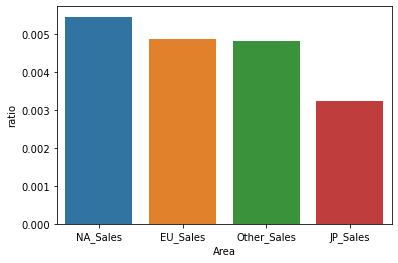

In [469]:

# (v)- P ( 지역(각각) | hit 게임 ) 
#   => df_P_Area_bar_hitGame
#
df_melt_hit = pd.melt(df_hit, id_vars=['Platform', 'Year' , 'Genre' , 'Type' , 'sum_Sales' , 'label' ] , var_name='Area', value_name='area_Sales' )
df_melt_hit.head()

df_temp = df_melt_hit.groupby( by = 'Area' ).sum().drop( columns= [ 'Year' , 'sum_Sales' ])
sales_all = df_temp.sum() #.values[0]
df_temp = df_temp / sales_all
df_temp.columns = ['ratio']
df_temp = df_temp.sort_values( by=['ratio'] , ascending= False )

df_P_Area_bar_hitGame = df_temp.copy()


# (v)- P ( 지역(각각) ). 
#   => df_P_Area
df_melt = pd.melt(df, id_vars=['Platform', 'Year' , 'Genre' , 'Type' , 'sum_Sales' , 'label' ] , var_name='Area', value_name='area_Sales' )
df_melt.head()

df_temp = df_melt.groupby( by = 'Area' ).sum().drop( columns= [ 'Year' , 'sum_Sales' ])
sales_all = df_temp.sum() #.values[0]
df_temp = df_temp / sales_all
df_temp.columns = ['ratio']
df_temp = df_temp.sort_values( by=['ratio'] , ascending= False )

df_P_Area = df_temp.copy()




"""
        목표 -> 각 지역 별로 매출이 높을 확률  ? 베이지안
            A : hit 게임
            B : 지역 (각)

            P(A|B) = P(B|A) * P(A) / P(B)

"""

# hit 게임의 장르
#P_hitGame_bar_Genre =  df_P_Genre_ratio_bar_hitGame [] * P_hit / P_ge
list_Area = df_melt_hit.Area.unique().tolist()

# P (hit 게임 | 각 지역별 )
df_P_hitGame_bar_Area = pd.DataFrame()

for Area in list_Area :
    sri_ratio = (df_P_Area_bar_hitGame.loc[Area] * P_hit / df_P_Area.loc[Area])
    df_insert = pd.DataFrame ({
        "Area" : Area ,
        "ratio" :  sri_ratio.values[0] # 값만 
    }, index = [Area] )
    df_P_hitGame_bar_Area = pd.concat( [df_P_hitGame_bar_Area , df_insert] , axis= 0)

# 정렬
df_P_hitGame_bar_Area = df_P_hitGame_bar_Area.sort_values( by=['ratio'] , ascending= False )
display(df_P_hitGame_bar_Area)


# # 시각화
sns.barplot ( data = df_P_hitGame_bar_Area , x = 'Area' , y = 'ratio' )
#(TODO) 퍼센트 값 추가







In [426]:

# # (TODO) , na_action = None 이 왜 안먹힐까?
# df_hit.groupby( by= 'Platform' ,dropna = True, )['sum_Sales'].mean().map( lambda x : x , na_action = None ).dropna()

### 1.4 분석 결과

언어 = 영어! , 일본어! , 유럽 언어? => 프랑스? , 독일? ...
지역 = 미국 , 유럽 , 일본 , 기타 

장르별 힛트 게임 확률은  
Shooter         2.6
Platform        1.6
Simulation      0.8
Misc            0.6
Racing          0.6
Role-Playing    0.5
Action          0.2

플랫폼별 힛트 게임 확률은
X360    1.4
3DS     1.0
Wii     0.6
PS3     0.6
PS4     0.5

### 1.5 사용된 가정 정리
    * 받은 데이터는 전체 모든 게임의 데이터가 아닌 일부 셈플 데이터임 ( 2109년 스팀 출시 게임만 8396개 임 ) 
        -> 분석은 신뢰도 95% 목표로 분석한다.
    * 외부 개발 의뢰가 아닌 자체 개발임
    * 개발 기간은 1년~2년 이라고 가정
    * 판매는 온라인 이지만, 마켓팅 비용은 지역 구분에 따라 추가 발생 함
    * 게임의 수익 비율은 장르별로 비슷하다고 가정
        장르별로 개발비용은 다르지만
        - 개발비용이 비싼 게임은 판매 가격도 비싸고, 개발 비용이 싼 게임은 판매 가격도 싸게 팔아서 수익율은 비슷 하다고 가정 한다.
    * 한 사람은 여러개의 게임을 구매 할 수 있다고 가정 -> 한개의 게임을 구매 후에도 다른 게임을 구매할 수 있음 ( 자금에 한도 없음 )
    * 매출 기본 단위는 , M ( 백만 , 10^6 )

----
## 2. 필수 목표 ( 별도 요청 사항 )

### 필수 목표는 최근 데이터 뿐만이 아닌 전체 데이터에 대한 분석 내용이어서 year 범위를 조정한다.

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000000 entries, 10459 to 7930
Data columns (total 10 columns):
 #   Column       Non-Null Count    Dtype   
---  ------       --------------    -----   
 0   Platform     1000000 non-null  category
 1   Year         1000000 non-null  int64   
 2   Genre        1000000 non-null  category
 3   NA_Sales     1000000 non-null  int64   
 4   EU_Sales     1000000 non-null  int64   
 5   JP_Sales     1000000 non-null  int64   
 6   Other_Sales  1000000 non-null  int64   
 7   Type         1000000 non-null  category
 8   sum_Sales    1000000 non-null  int64   
 9   label        1000000 non-null  category
dtypes: category(4), int64(6)
memory usage: 57.2 MB
   label       max       min   count  cum_sum
4      4  82740000  82740000      72       72
7      7  40240000  28310000     558      630
1      1  24750000  17280000     828     1458
6      6  16380000   8770000    3279     4737
2      2   8490000   4300000   11159    15896
5      5   4260000

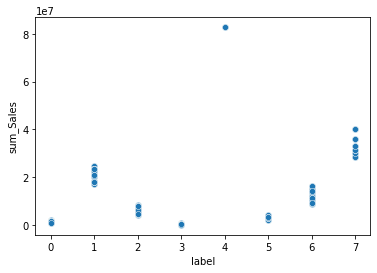

In [541]:
df = df_target

#(v) 부트 스트랩 ( 10만개 )
df_boot = df.sample(n=1000000, replace=True)
df_boot.reset_index ( drop= True)
df_boot.head()
df_boot.info()

# 작업 df = 
df = df_boot


#(v) Kmeans 실행 하여 클러스터 나누기
# K-means 클러스터링 분석
kmeans = KMeans( random_state=42)

# (v) 부트스트랩을 한 data를 기준으로 클러스터링 진행
# (TODO) 혹시 셈플(원본) 데이터를 클러스터링 분류 기준으로 잡아야 하는가?
kmeans.fit_transform( np.array(df.sum_Sales.to_list()).reshape(-1, 1))    #(TODO) reshape(-1, 1) 해주어야 하는 이유 확인

# # 최근연도의_부트스트렙_ 셈플 데이터를 클러스터링 하기
# kmeans._transform(np.array(df_boot.sum_Sales.to_list()).reshape(-1, 1))
cluster_labels = kmeans.labels_

#(TODO)결과가 몇개의 클러스터 나뉘었는지 확인하는 간단한 방법이 뭐였더라?)
set_cluster = set(cluster_labels )
len(set_cluster)

#(v) 어느 클러스터가 최고 매출 클러스터인지 확인 
df['label'] = cluster_labels
df['label'] = df['label'].astype('category')

#(TODO) y값이 정상으로 출력되지 않는 이유는?
sns.scatterplot ( data = df , y= 'sum_Sales' , x = 'label' )

#[v] 어느 그룹까지를 hit-game으로 보면 좋을지 결정 하기
# (TODO) 어떤 방법으로 나누는 것이 좋을까? 

# K-Means
df_label_max = pd.DataFrame ()
for i in range (len(set_cluster)) :
        df_insert = pd.DataFrame(
                        {
                                'label' : i ,
                                'max' : df[df.label == i ].sum_Sales.max() , 
                                'min' : df[df.label == i ].sum_Sales.min() , 
                                'count' : len(df[df.label == i ])
                        }
                        , index=[i]
                )
        #print(df_insert)
        df_label_max = pd.concat( [df_label_max , df_insert] , axis= 0)
        

#(v) max() 값 순으로 정렬하여 출력하는 방법은?
df_label_max.sort_values(by='max' , axis=0, ascending=False, inplace=True)
df_label_max['cum_sum'] = df_label_max['count'].cumsum()
print(df_label_max)


# 상위 10% 값의 경우에는? 
upper = np.percentile(df.sum_Sales, 90) 
print ( f" 상위 10% =  {upper}  ")


In [542]:
# hit game의 cluster 정하기
list_cluster_hit_game = df_label_max.iloc[:4]['label'].values.tolist()
print (list_cluster_hit_game)

#(v)- p ( hit 게임)
df_label_ratio = df['label'].value_counts(normalize=True ,dropna = True)
P_hit = df_label_ratio.sort_values( )[:4].sum()
display( P_hit )

# hit 게임
df_hit = df.query ( "label in @ list_cluster_hit_game "   )
df_hit.reset_index ( drop=True)
#(TODO)
#df_hit = df.loc[ (df.label in [2, 4]).any() ] 
#df_hit = df[ ((df['label'] == 3 ) | ( df['label'] == 1 ))  ]

df_hit.head()


[4, 7, 1, 6]


0.004737

,Platform,Year,Genre,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Type,sum_Sales,label
6322,N64,1996,Platform,6910000,2850000,1910000,230000,console,11900000,6
12337,X360,2010,Shooter,7030000,1980000,80000,780000,console,9870000,6
7673,GB,1996,Role-Playing,11270000,8890000,10220000,1000000,portable,31380000,7
14265,X360,2012,Shooter,6630000,2360000,40000,730000,console,9760000,6
12211,DS,2004,Platform,5080000,3110000,1250000,980000,portable,10420000,6


In [726]:
# hit 컬럼에 hit game 여부 표시 하기
df['hit'] = df.label.apply ( lambda x : True if x in list_cluster_hit_game else False   )  

### 2-1. 지역에 따라서 선호하는 게임 장르가 다를까 라는 질문에 대답을 하셔야합니다.

가설검증 
    : 지역별 선호 게임장르는 다른가?  
    
        -> 접근방법: 세부 가설검증으로 나눠서 분할 확인 후 결과를 합친다

        1.  전체중에서 선호 장르가 무엇인지 확인
            -> 결과 : 전체중 선호장르 = a

                * 부트 스트랩
                * 각 장르별 순위 집계
                * 모수 전체에 대한 선호 장르 확정 -> 오차율은? 의미가 있을까?

        2. 각 지역별로 가설검증

            ho = 전체의 최선호 장르
            h0 = a (a: 별도의 분석으로 구해진 값)
            h1 = A 지역의 최선호 장르

            귀무가설 : h1 = a
            대립가설 : h1 != a

        3. 2번 검증을 지역별로 모두 수행중에 하나라도 대립가설인 경우가 있으면 
            -> 지역별로 다름 
            anova를 이용해서 혹은 반복수행을 통해 검증한다.


결과 출력  

        -(DF) 지역 , 장르 , 장르별 매출 , 지역내 장르별 매출 비율
        -(그래프) 표 : x: 지역 , x-sub 장르 , y: 지역내 장르별 매출 비율 

        X ->추가1) 시간대별로 지역의 선호도가 달라지지 않았는지 확인
            -(DF) 지역 , 연도 , 장르 , 장르별 매출 , 지역내 장르별 매출 비율
            -(그래프) 표 : x:연도 , x-sub 지역 , sub 장르 , y: 지역내 장르별 매출 비율 
                -> 너무 복잡하다 
                    -> 단순하게? 어떻게?


### 2-2. 연도별 게임의 트렌드가 있을까 라는 질문에 대답을 하셔야합니다.
### 2-2-1 트렌드 => 최 선호 장르

가설검증 
    : 연도별 트렌드가 있다?

        트렌드란? 무엇 ? 
            : 트렌드 -> 배운것을 이용해서 수치로 나타낼 수 있을까?
                경향?
            
            * 트랜드 = 장르별 비율 ?
                -> 장르갯수 만큼의 차원을 가진 백터로 표현 하면 되지 않을까? 
                    방향이 같으면 경향이 같다고 판단할 수 있을것으로 보임
                    -> 그렇다면 크기는 해당 연도의 매출에 관계 있는걸까?

                    h0 = 1번째 연도의 트렌드 값 => n차원 벡터
                    h1 = 2번째 연도의 트렌드 값 => n차원 벡터
                    ...
                    hn 

                귀무가설 : h0 = h1 = h2
                대립가설 : h0 != h1 != h2

                anova를 이용해서 검증한다.

            -> 구현 불가 ( 벡터의 유사도를 구하는 방법을 아직 모른다.)
                -> 단순화 시켜야 함
                    -> "최선호 장르" 를 트렌드로 가정한다.( 가장 잘 팔리는 장르를 찾는 것이 요청자의 관심사 일 것이므로)

            * 트렌드 = 최선호 장르 


                    h0 = 1번째 연도의 최선호 장르 
                    h1 = 2번째 연도의 최선호 장르
                    ...
                    hn 

                귀무가설 : h0 = h1 
                            h1 = h2 ... 반복 
                대립가설 : h0 != h1
                            h1 != h2 ... 반복

                - 반복검증하여 하나라동 대립가설을 만족하는 경우 -> 대립가설 채택
                - (TODO) anova를 이용해서 검증한다.

            * TODO 사람이 인식하지 못한 요소를.... 머신러닝을 이용해서 어떤 트렌드가 있다는 걸 찾아낼 수 있을까? 

그래프 :

        -(DF) 연도, 장르 , 장르별 매출 , 장르별 매출 비율 
        -(그래프) (bar) x: 연도 , sub 장르 , y: 장르별 매출 비율

        -(그래프) (꺽은선) x: 연도 , y: 매출비율 , hue : 장르
            + (bar) x : 연도 , y : 전체매출  
            or + (bar:누적) x : 연도 , y : 장르별 매출 , hue= 장르  

        X ->추가2?> 지역별로도 선호도가 달라지는가? 
            - 추가 1과 다른가? 의미가 있나? 
            -> 추가 1 처럼 너무 복잡해 질 것임 

결과 분석 :
    


In [ ]:


#(v) 연도별 hit game의 전체 매출 비중 변화
df_temp_01 = df.groupby ( by = ['Year' ] ).sum()
df_temp_01.head()

df_temp_02 = df_hit.groupby ( by = ['Year' ] ).sum()
df_temp_02.head()

df_temp = pd.merge( left = df_temp_01 , right = df_temp_02 , how='left' , left_index = True, right_index = True)
df_temp = df_temp.fillna(0)


df_temp = df_temp[ ['sum_Sales_x' , 'sum_Sales_y'] ]
df_temp.columns = [ 'All', 'Hit' ]
df_temp['Hit'] = df_temp['Hit'].astype('int')
df_temp['Hit_ratio'] = (df_temp['Hit'] / df_temp['All']).round(2)


df_temp['Year']= df_temp.index
df_melt = pd.melt(df_temp, id_vars=['Hit_ratio' ,'Year' ] , var_name='gubun' , value_name='sum_Sales' )
df_melt

# 시각화
plt.figure( figsize = (20,5) )
sns.barplot ( data = df_melt , y = 'sum_Sales' , x = 'Year' , hue = 'gubun')


# 셈플 데이터가 안 좋아서 최근 데이터가 많이 부족한 것으로 보임






### 2-2-2 트렌드 => 최 선호 플렛폼


### 2-3. 출고량이 높은 게임에 대한 분석 및 시각화 프로세스가 포함되어야 합니다.
    *(v) hit game 의 전체 매출 비중
    *(v) 연도별 hit game의 전체 매출 비중 변화
    *(v) hit game 의 장르별 비율
    *(v) hit game 의 플렛폼별 비율  


#  hit game의 전체판매량 / 전체 판매량 = 15.0 %


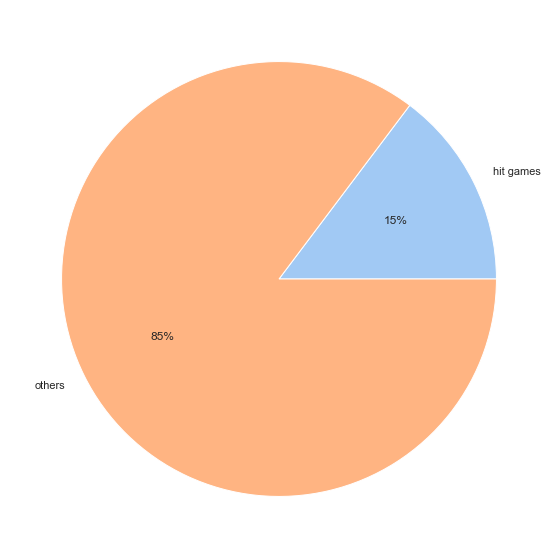

In [752]:
# hit game 의 전체 매출 비중
all_sales_df_boot = df.sum_Sales.sum()
all_sales_df_hit =  df_hit.sum_Sales.sum()

print ( f"#  hit game의 전체판매량 / 전체 판매량 = { np.round((all_sales_df_hit / all_sales_df_boot),2) * 100 } %")


# 시각화 
lst_tmp = [ all_sales_df_hit , ( all_sales_df_boot - all_sales_df_hit )]
keys = [ 'hit games' , 'others']

# plotting data on chart
plt.figure( figsize = (10,10) )
plt.pie ( x=lst_tmp , labels=keys, autopct='%.0f%%' , colors=colors)
plt.show()
  


<AxesSubplot:xlabel='Year', ylabel='sum_Sales'>

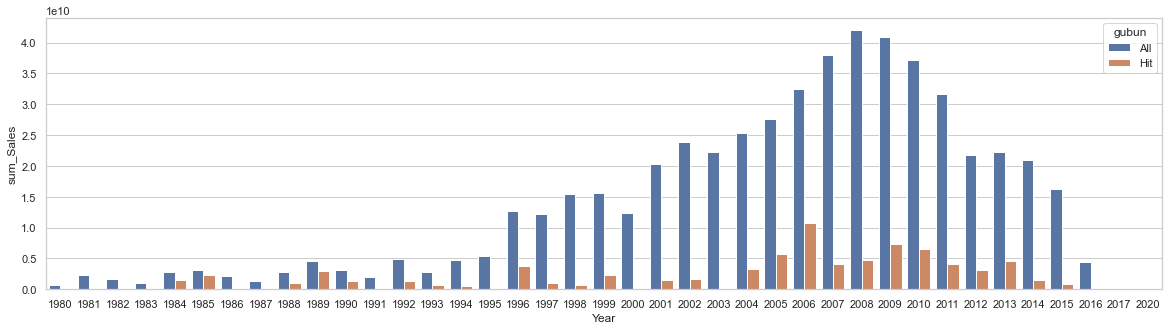

In [755]:
#(v) 연도별 hit game의 전체 매출 비중 변화
df_temp_01 = df.groupby ( by = ['Year' ] ).sum()
df_temp_01.head()

df_temp_02 = df_hit.groupby ( by = ['Year' ] ).sum()
df_temp_02.head()

df_temp = pd.merge( left = df_temp_01 , right = df_temp_02 , how='left' , left_index = True, right_index = True)
df_temp = df_temp.fillna(0)


df_temp = df_temp[ ['sum_Sales_x' , 'sum_Sales_y'] ]
df_temp.columns = [ 'All', 'Hit' ]
df_temp['Hit'] = df_temp['Hit'].astype('int')
df_temp['Hit_ratio'] = (df_temp['Hit'] / df_temp['All']).round(2)


df_temp['Year']= df_temp.index
df_melt = pd.melt(df_temp, id_vars=['Hit_ratio' ,'Year' ] , var_name='gubun' , value_name='sum_Sales' )
df_melt

# 시각화
plt.figure( figsize = (20,5) )
sns.barplot ( data = df_melt , y = 'sum_Sales' , x = 'Year' , hue = 'gubun')


# 셈플 데이터가 안 좋아서 최근 데이터가 많이 부족한 것으로 보임


In [742]:
sum_Sales_all = df_hit.sum_Sales.sum() 
sum_Sales_all

79729569674

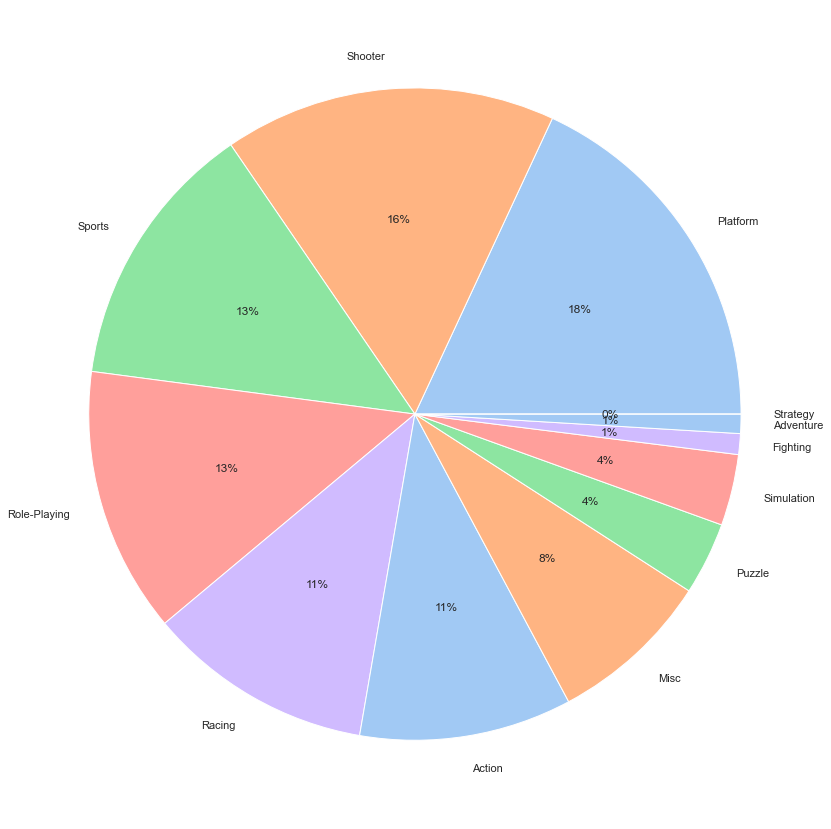

In [756]:
#*(v) hit game 의 장르별 비율
df_tmp = df_hit.groupby (  by = 'Genre' )['sum_Sales'].sum()
df_tmp = df_tmp.sort_values( ascending=False)

# # 시각화 
plt.figure( figsize = (15,15) )
plt.pie ( x= df_tmp , labels=df_tmp.index, autopct='%.0f%%' , colors=colors)
plt.show()
  

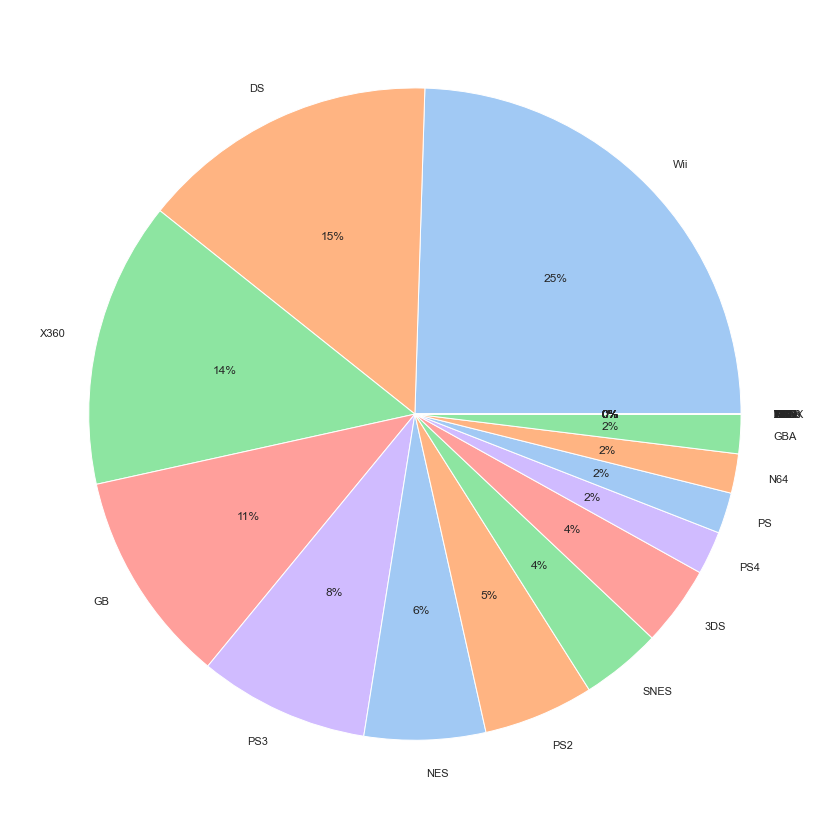

In [757]:
#(v) hit game 의 플렛폼별 비율

df_tmp = df_hit.groupby (  by = 'Platform' )['sum_Sales'].sum()
df_tmp = df_tmp.sort_values( ascending=False)

# # 시각화 
plt.figure( figsize = (15,15) )
plt.pie ( x= df_tmp , labels=df_tmp.index, autopct='%.0f%%' , colors=colors)
plt.show()

## 3. 기타 사항 ( 추가 적인 참고 사항 , 분석 도중 추가 도출 된 사항)
